Simple example of U-net for segmentation in Keras

# Introduction

    This notebook demonstrates a simple implementation of a U-Net model for image segmentation using Keras. The goal is to segment defects in images.
  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2

import keras
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras import Model
from keras import backend as K
from keras.layers import Lambda
import os

import tensorflow as tf
from tensorflow import keras

# Dataset

    This section loads and preprocesses the dataset. We are using a dataset with images and corresponding RLE (Run-Length Encoding) masks for segmentation.

In [12]:
tr = pd.read_csv('/content/drive/MyDrive/dd/train.csv')
print(len(tr))
tr.head()

7095


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [13]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
print(len(df_train))
df_train.head()

7095


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [14]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]

    mask= np.zeros( width*height ).astype(np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]

    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [15]:
img_size = 256

In [16]:
def keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            fn = df_train['ImageId'].iloc[i]
            img = cv2.imread( '/content/drive/MyDrive/dd/train_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)

            img = cv2.resize(img, (img_size, img_size))
            mask = cv2.resize(mask, (img_size, img_size))

            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [17]:
for x, y in keras_generator(20):
    break

print(x.shape, y.shape)

(20, 256, 256, 3) (20, 256, 256, 1)


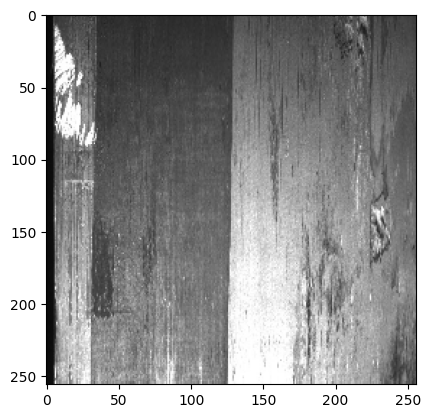

In [18]:
plt.imshow(x[6])

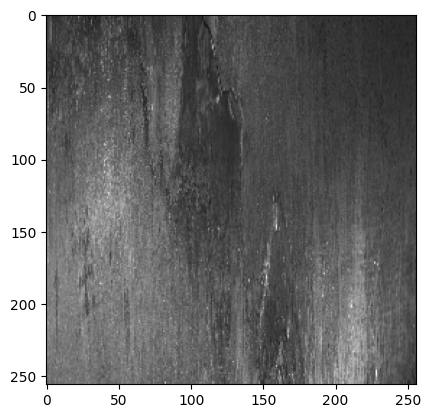

In [19]:
plt.imshow(x[3])

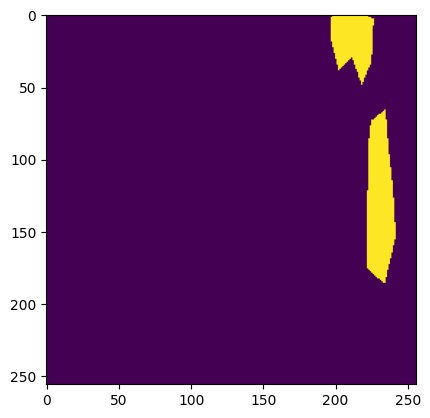

In [20]:
plt.imshow(np.squeeze(y[6]))

# Model

    This section defines and compiles the U-Net model architecture.

In [21]:
#Model

inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [22]:
#Importing All keras layers to help in model building
!pip install visualkeras
import visualkeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 49.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


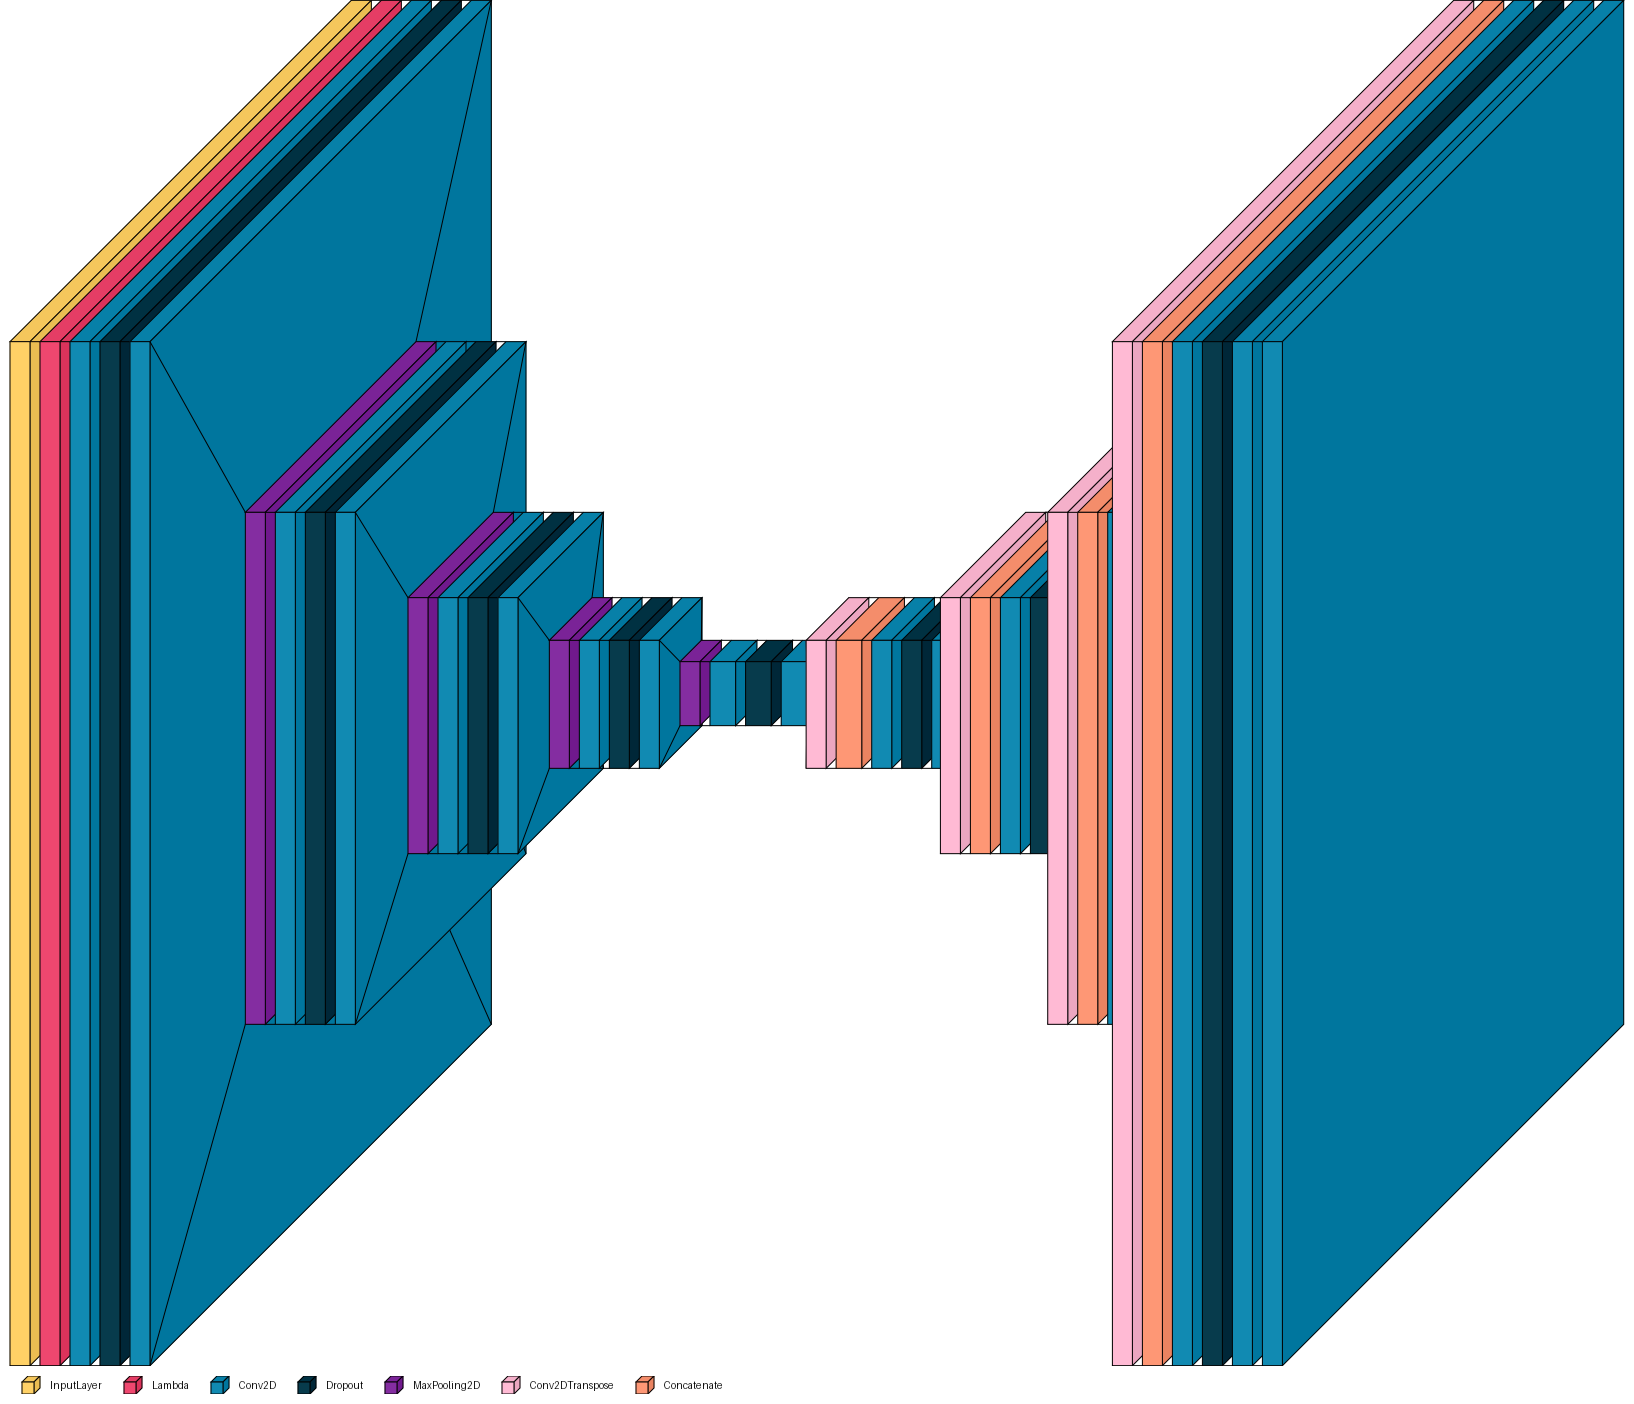

In [23]:
#Visualizing The Network Architecture
visualkeras.layered_view(model, to_file='AlexNet_architecture.png').show()
#Saves the architecture as an image file
visualkeras.layered_view(model)
#To annotate the architecture
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

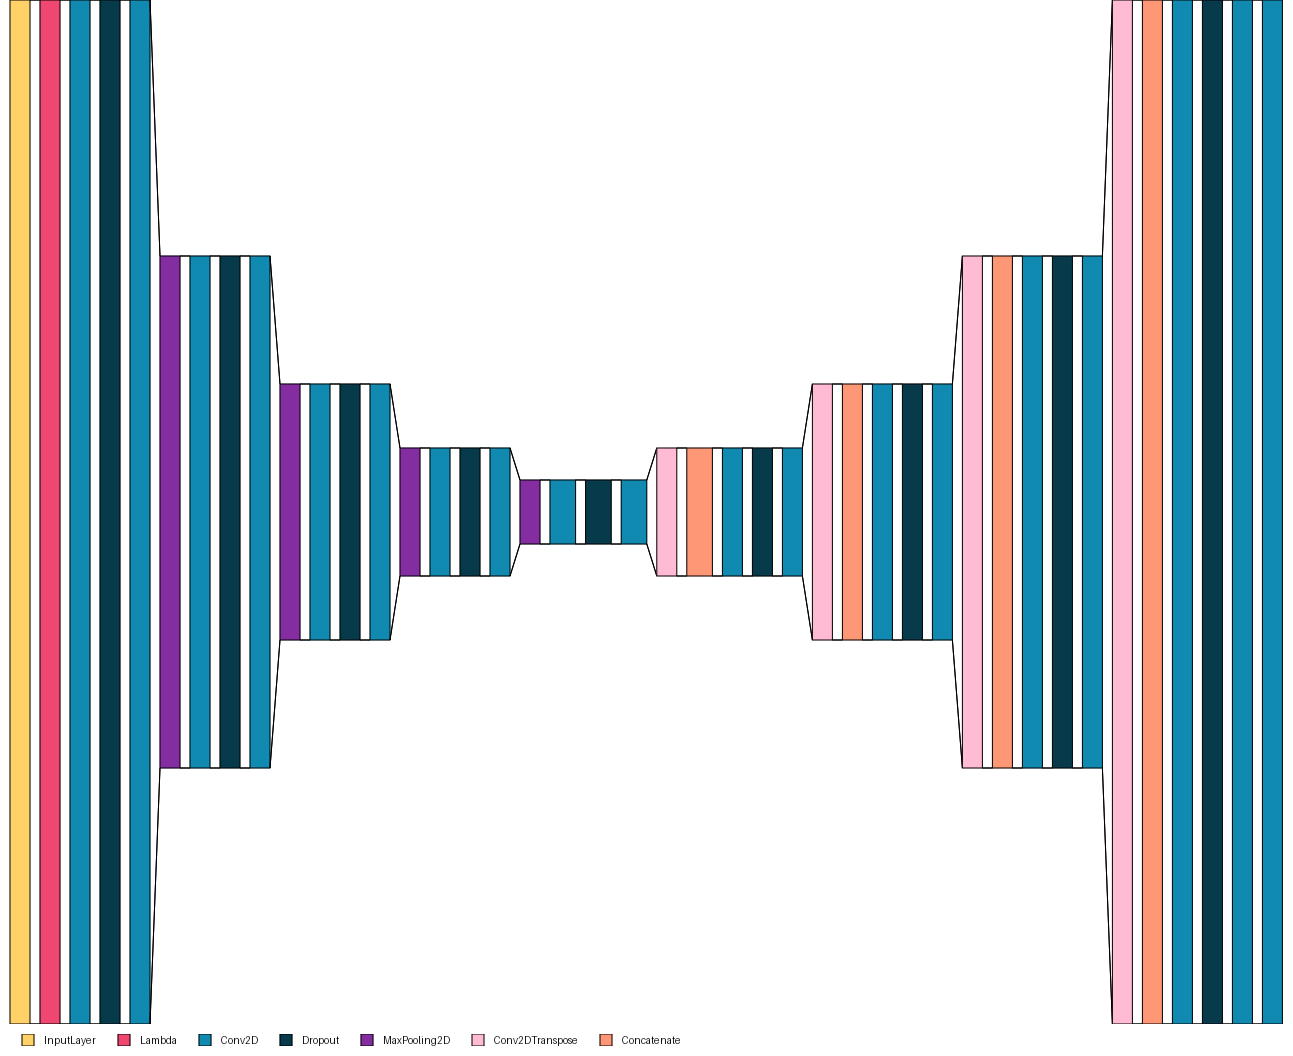

In [24]:
#For a flat view of the architecture
visualkeras.layered_view(model, draw_volume=False, legend = True)

# Training and Results

    This section covers training the model and visualizing the results, including predictions and evaluation metrics.

In [ ]:
%%time
# Fit model
batch_size = 16
results = model.fit(keras_generator(batch_size),
                              steps_per_epoch=100,
                              epochs=10)

In [ ]:
pred = model.predict(x)
plt.imshow(np.squeeze(pred[4]))

In [ ]:
plt.plot(results.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
testfiles=os.listdir("/content/drive/MyDrive/dd/test_images/")
len(testfiles)

In [ ]:
%%time
test_img = []
for fn in tqdm_notebook(testfiles):
        img = cv2.imread('/content/drive/MyDrive/dd/test_images/'+fn )
        img = cv2.resize(img,(img_size,img_size))
        test_img.append(img)

In [ ]:
%%time
predict = model.predict(np.asarray(test_img))
print(len(predict))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(predict, axis = -1)

y_true = np.argmax(np.asarray(test_img), axis= -1)

cm = confusion_matrix(np.asarray(test_img),predict)
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

In [ ]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [ ]:

pred_rle = []
for img in predict:
    img = cv2.resize(img, (1600, 256))
    tmp = np.copy(img)
    tmp[tmp<np.mean(img)] = 0
    tmp[tmp>0] = 1
    pred_rle.append(mask2rle(tmp))

In [ ]:
img_t = cv2.imread( '/content/drive/MyDrive/dd/test_images/'+ testfiles[10])
plt.imshow(img_t)

In [ ]:
mask_t = rle2mask(pred_rle[10], img.shape)
plt.imshow(mask_t)

In [ ]:
sub = pd.read_csv( '/content/drive/MyDrive/dd/sample_submission.csv' )
sub.head()

In [ ]:

print(tf.version.VERSION)

In [ ]:
score = model.evaluate(x , y)

In [ ]:
model.summary()

In [ ]:
#save model as h5
model.save('AI_proj.h5')

In [ ]:
#load model/recreate model
new_model = tf.keras.models.load_model('AI_proj.h5')

In [ ]:
%%time
for fn, rle in zip(testfiles, pred_rle):
    sub['EncodedPixels'][sub['ImageId'] == fn] = rle

In [ ]:
sub.head(8)

In [ ]:
img_s = cv2.imread( '/content/drive/MyDrive/dd/test_images/'+ sub['ImageId'][279])
plt.imshow(img_s)

In [ ]:
mask_s = rle2mask(sub['EncodedPixels'][279], (256, 1600))
plt.imshow(mask_s)

In [ ]:
sub.to_csv('submission.csv', index=False)